## PSF Photometry using PAL5 3.6um Spitzer mosaic

This notebook builds on the earlier work on PSF photometry in order to refine the parameters used and the ensure the code is working as expected and understood correctly. Afterwhich this method will be applied to all 12 time epochs and the 4.5um band.

First start with the list of relevant modules for this notebook:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from astropy.io import fits # used for FITS file management
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground

In the usual way we import the file of interest and extract some details from the header of the FITS file, convert to counts etc, only this time introducing some generality to the code such that it is not locked into one particular file or method.

PAL5_data/PAL5/PAL5_3p6um.fits
FLUXCONV = 0.1257
EXPTIME = 585.054


82


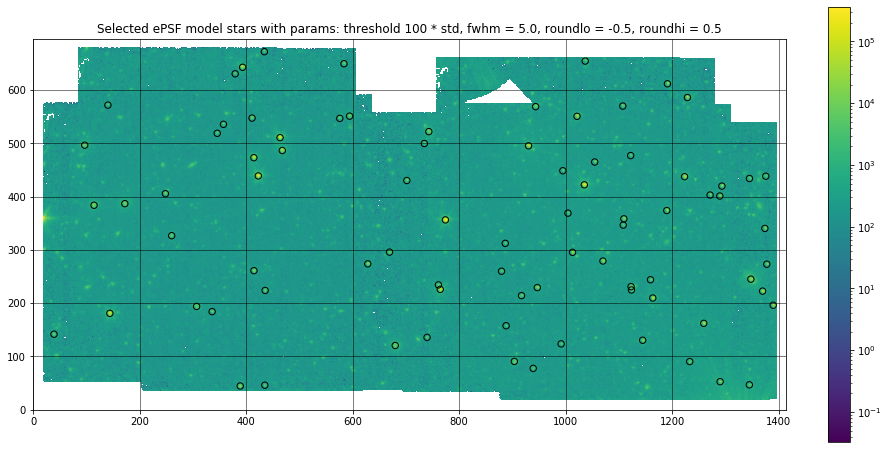

In [2]:
## DEFINING BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/PAL5/'
channel = '3p6um'

file = base_dir+'PAL5_'+channel+'.fits'
print(file)

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(file) as header_list:
    header = header_list[0].header
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    counts = exptime / fluxconv
    image_data = fits.getdata(file, ext = 0)
    data = image_data * counts
    print('FLUXCONV = {}\nEXPTIME = {}'.format(fluxconv, exptime))
#___________________________________#
## BUILDING ePSF MODEL FOR PHOTOMETRY
## SOURCE DETECTION FOR ePSF MODEL ##

# PARAMETERS #
sigma_val = 5.
fwhm = 5.
threshold = 100
roundlo = -0.5
roundhi = 0.5

mean, median, std = sigma_clipped_stats(data, sigma = sigma_val)

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = threshold * std, roundlo = roundlo, roundhi = roundhi)
epsf_sources = starfind_init(data)
print(len(epsf_sources))

# plot detected stars for ePSF model to verify good stars
positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
apertures = CircularAperture(positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Selected ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

In [3]:
## APERTURE PHOTOMETRY ##
positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
circular_apertures = CircularAperture(positions, r = 6.)
annuli_apertures = CircularAnnulus(positions, r_in = 6., r_out = 14.)
apertures = [circular_apertures, annuli_apertures]

# initial aperture photometry table
phot_init = aperture_photometry(data, apertures)

# background subtraction using sigma-clipped median and annuli
annulus_masks = annuli_apertures.to_mask(method = 'center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0] # extract 1D array of data values
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
# now append bkg_median, aperture background and aperture sum background values to photometry data
phot_init['annulus_median'] = bkg_median
phot_init['aper_bkg'] = bkg_median * circular_apertures.area
phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']
print(phot_init)

 id      xcenter       ...      aper_bkg       aper_sum_bkgsub  
           pix         ...                                      
--- ------------------ ... ------------------ ------------------
  1  388.5643966406068 ...  32015.61120598642  322430.4623181619
  2  434.8194022933505 ...    25150.689570927  82217.14853755586
  3 1344.9425064804868 ...  53700.70166004442 124397.40231768812
  4 1290.0140281406764 ...  57062.67251304021   271029.249020998
  5  938.9457034595329 ... 27150.577523127617  88848.09400136855
  6  903.5050731205179 ...  36610.50972161297 223566.70147270372
  7 1232.9300012743536 ...  34884.79168961194 108607.58025913624
  8  679.8036346595079 ...  48593.31703697394  301159.5278271151
  9  991.3280373263775 ... 30017.395484592198  86107.08153782108
 10 1144.5598781503932 ... 33722.655131118525 271543.48279992945
...                ... ...                ...                ...
 73   943.554028495274 ...  34022.43313484348 215340.38046260228
 74 1107.2475758751827 ..

60


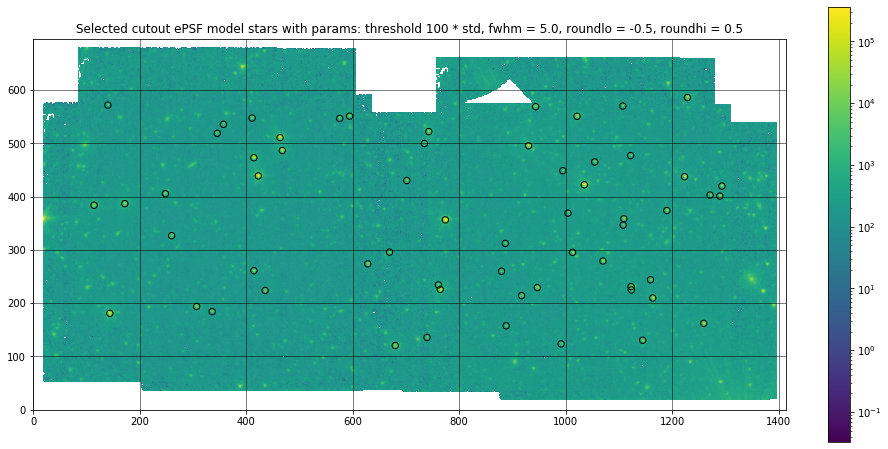

In [4]:
## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

# table of star positions
star_tbl = Table()
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
print(len(star_tbl))

# visualise stars to verify
cutout_pos = np.transpose((star_tbl['x'], star_tbl['y']))
cutout_apers = CircularAperture(cutout_pos, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
cutout_apers.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Selected cutout ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

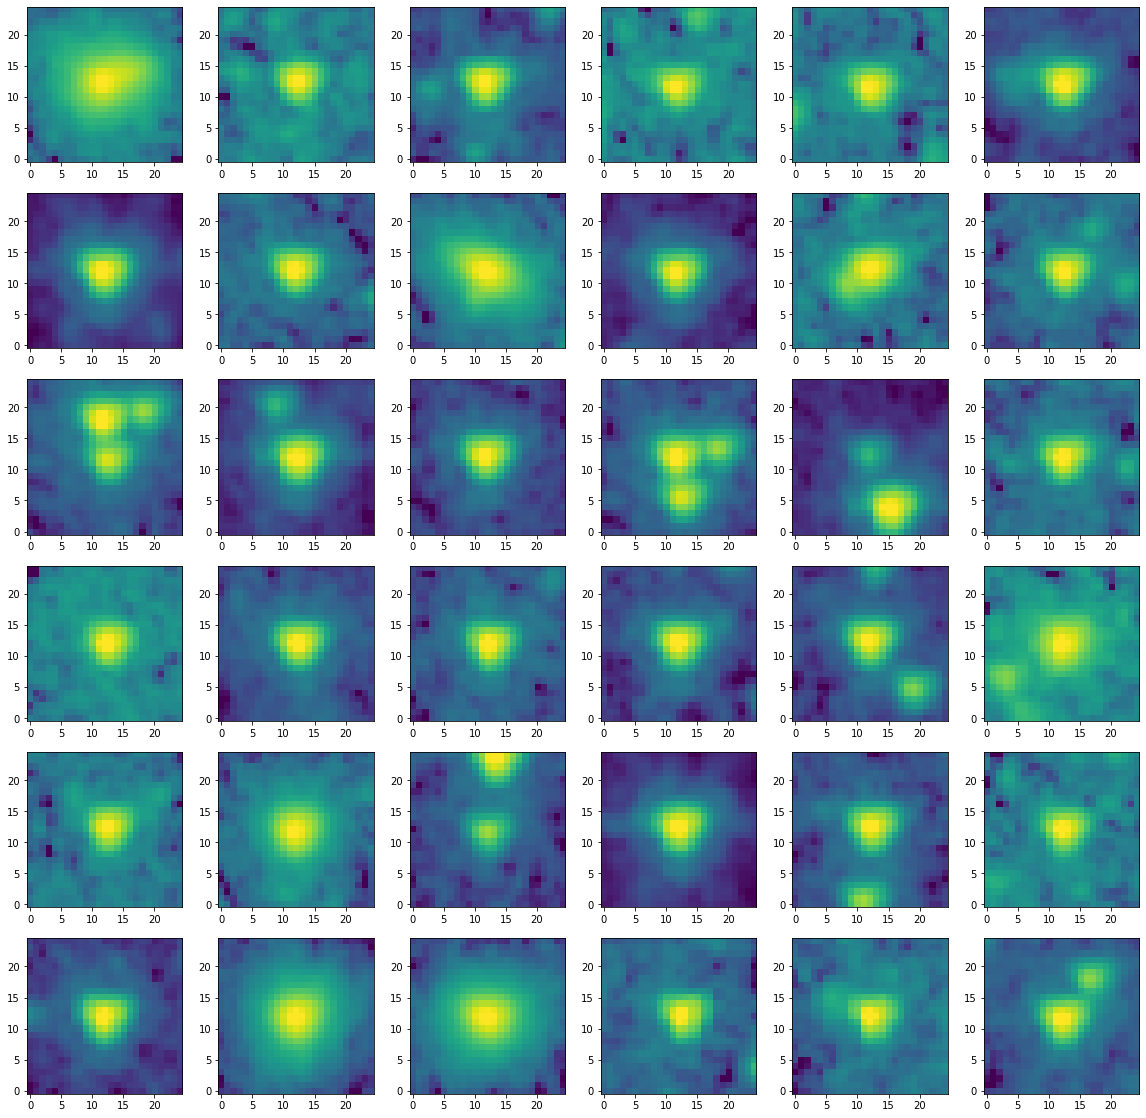

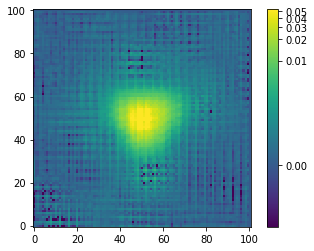

In [5]:
## EXTRACT STARS ##

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = 5.)
temp_data = data - median_val

nddata = NDData(data = temp_data)
stars = extract_stars(nddata, star_tbl, size = 25)

# visualise 36 extracted stars
nrows = 6
ncols = 6
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent = 99.)
    ax[i].imshow(stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
plt.show()
plt.close()
    
## BUILD ePSF ##

epsf_builder = EPSFBuilder(oversampling = 4, maxiters = 10, progress_bar = True)
epsf, fitter = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent = 99.)
plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
plt.colorbar()
plt.show()

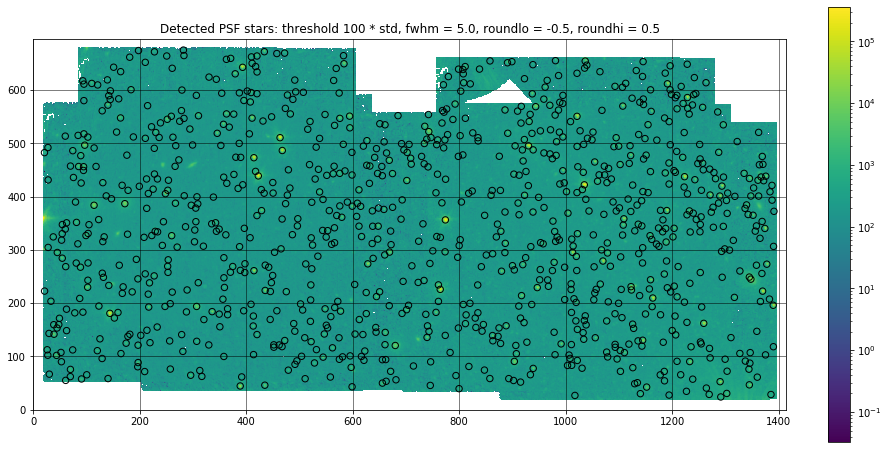

Number of stars detected = 998


1171


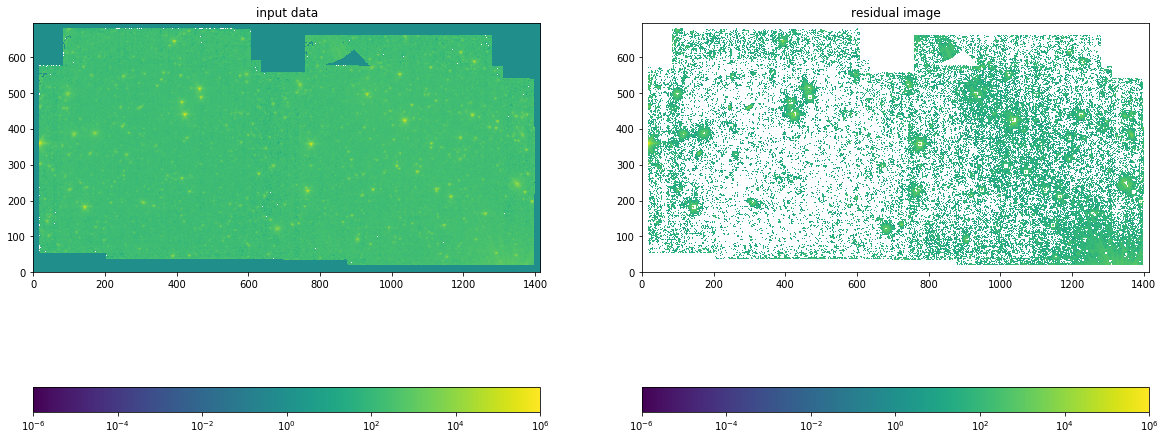

In [6]:
## PSF PHOTOMETRY ##

## SOURCE DETECTION ON ORIGINAL IMAGE ##
# PARAMETERS #

sigma_psf = 5.
fwhm = 5.
roundlo = -0.5
roundhi = 0.5

psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_psf * std, roundlo = roundlo, roundhi = roundhi)
psf_sources = psf_daofind(data)

psf_positions = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
psf_apertures = CircularAperture(psf_positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
psf_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Detected PSF stars: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

print('Number of stars detected = {}'.format(len(psf_sources)))

## GROUP ##

psf_sources['xcentroid'].name = 'x_0'
psf_sources['ycentroid'].name = 'y_0'

daogroup = DAOGroup(crit_separation = sigma_psf * fwhm)
bkg_estimator = MMMBackground()
fitter = LevMarLSQFitter()

data_psf = np.nan_to_num(data, nan = 1**-7)

## PHOTOMETRY ##

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = bkg_estimator,
                                                    psf_model = epsf,
                                                    fitter = fitter,
                                                    niters = 2,
                                                    aperture_radius = 6.,
                                                    fitshape = (11, 11))

result_phot = PSF_photometry(image = data_psf)
residual_image = PSF_photometry.get_residual_image()
print(len(result_phot))
# visualise data
plt.subplot(1, 2, 1)
plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('input data')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('residual image')
plt.colorbar(orientation = 'horizontal')
plt.gcf().set_size_inches(20, 14)
plt.show()

In [7]:
## APPARENT MAGNITUDES ##
aper_corr = 1.125      # aperture correction for 337 (6,6,14) apertures in channel 1, given in IRAC handbook §4.10
zeropoint_flux = 280.9 # see Reach et al. 2005
zmag = 18.8            # from IRAC handbook §4.8

phot = result_phot                  # redefine photometry table for ease
phot['bkgsub_flux'] = float('NaN')  # populate new column to convert into flux
phot['apparent_mag'] = float('NaN') # populate a new table (very quirky here, nans?)

for i in range(0, len(phot)):
    phot['bkgsub_flux'][i] = phot['flux_0'][i] * fluxconv / exptime
    for i in range(0, len(phot)):
        if phot['bkgsub_flux'][i] >= 0:
            phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['bkgsub_flux'][i] * aper_corr)

# export into csv file
phot['id', 'x_0', 'y_0', 'apparent_mag'].write(r'C:\Users\lukeb\Documents\MPhys_Project\output_files\psfphot01.txt', format = 'csv', overwrite = True)
           
# format columns
for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot['id', 'x_0', 'y_0', 'flux_0', 'apparent_mag'])

 id    x_0       y_0      flux_0   apparent_mag
--- --------- --------- ---------- ------------
  1   1306.64 21.371443  58182.039    15.929798
  8 1302.5324 30.413832   86161.17    15.503491
  2 1393.4269 21.721092 -344.81264          nan
  6 1385.5651 28.366621  31371.168    16.600444
  3 1017.3142 26.634326  7157.1347    18.204922
  4 1194.2221 27.325663  4086.5772    18.813371
  5 1269.5063 28.576869  40601.399    16.320418
 15 1264.2162 40.472713  27373.788    16.748433
  7  1140.274 29.994286  23584.186    16.910218
 16 1152.0517 42.328688  130057.42    15.056433
...       ...       ...        ...          ...
137 85.691509 613.34674 -3622.8961          nan
138 603.91803 613.48344 -1227.9858          nan
139 1033.8585 633.54431  2903.1869    19.184583
140 813.67347 641.31361  7949.2273    18.090958
141 810.24559 647.02269  1773.7261    19.719554
142  384.2729 648.98335  33339.796    16.534363
143 1194.1914 651.19168  7975.2581    18.087409
145 1211.6955 657.63474 -3288.5325      